# BiRNN

采用预训练模型，并且句子提前填充与截断

In [1]:
import torch
import os
import sys
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(r'D:\code\Python-Project\文本数据挖掘\WBClassify')))
from WBClassify.Utils import utils,vocab,Trie
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import random 

In [2]:
def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed_torch()

In [3]:
def collate_fn(data):               # 传入的数据，对数据的输出形式进行设定
    inputs = [torch.tensor(i[0]) for i in data]
    targets = torch.tensor([i[1] for i in data], dtype=torch.long)
    return torch.stack(inputs), targets
train_data_loader,test_data_loader,vocab_,encoder = utils.load_data(batch_size=64,is_truncate_pad=True,collate_fn=collate_fn,
                                                                    is_dropword=True,is_gotchinese=False,method="jieba")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.583 seconds.
Prefix dict has been built successfully.


In [4]:
for x,y in train_data_loader:
    print(x)
    print(y)
    break

tensor([[   31,    25,  3221,  ...,     1,     1,     1],
        [   51,  5710,    15,  ...,     1,     1,     1],
        [ 2590,  1231, 11868,  ...,     1,     1,     1],
        ...,
        [  335,   101,   716,  ...,     1,     1,     1],
        [ 8363,  3964,  8364,  ...,     1,     1,     1],
        [ 1715,    33,   400,  ...,     1,     1,     1]])
tensor([1, 3, 2, 1, 4, 0, 1, 2, 0, 1, 0, 0, 4, 1, 1, 0, 0, 4, 2, 4, 2, 4, 1, 3,
        3, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 3, 4, 1, 3, 3, 1, 2, 2, 4, 2, 1, 2,
        2, 1, 1, 0, 4, 2, 0, 2, 0, 4, 0, 1, 3, 3, 1, 4])


In [5]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Sequential(
            nn.Linear(4 * num_hiddens, len(encoder.classes_)),
        )

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()           # 就是重置参数的数据指针，提高内存利用率和效率
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [6]:
from d2l import torch as d2l

embed_size, num_hiddens, num_layers = 300, 300, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab_), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)
embeds = utils.TokenEmbedding(vocab_.idx_to_token)
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False;

loss 0.001, train acc 1.000, test acc 0.871
2424.6 examples/sec on [device(type='cuda', index=0)]


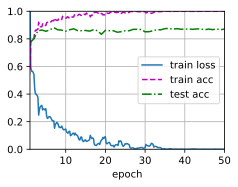

In [7]:
lr, num_epochs = 0.001, 50
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")            # 反向传播的时候
d2l.train_ch13(net, train_data_loader, test_data_loader, loss, trainer, num_epochs,
    devices)